In [24]:
import numpy as np
import pandas as pd
import os

import random
from PIL import Image, ImageDraw
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


import torch
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


# Convert Coco JSON Annotations to YOLO TXT Files
Use this notebook to try out importing, analyzing, and exporting datasets of image annotations. 

In [14]:
import logging

logging.getLogger().setLevel(logging.CRITICAL)
# !pip install pylabel > /dev/null

In [15]:
from pylabel import importer

## Import coco annotations 
First we will import annotations from the coco dataset, which are in coco json format. 

In [ ]:
import os
# import zipfile

# Download dataset
os.makedirs("data", exist_ok=True)
# !wget "https://github.com/pylabelalpha/notebook/blob/main/BCCD_coco.zip?raw=true" -O data/BCCD_coco.zip
# with zipfile.ZipFile("../data/helloListenDog_v1_dog_detection.v1i.coco.zip", 'r') as zip_ref:
#   zip_ref.extractall("data")

# Specify path to the coco.json file
path_to_annotations = "../combined_coco.json"
# Specify the path to the images (if they are in a different folder than the annotations)
path_to_images = "data/renamed_dub_removed/"

# Import the dataset into the pylable schema
dataset = importer.ImportCoco(
    path_to_annotations, path_to_images=path_to_images, name="DOG"
)
dataset.df[
    [
        "img_folder",
        "img_filename",
        "img_path",
        "img_id",
        "img_width",
        "img_height",
        "ann_bbox_xmin",
        "ann_bbox_ymin",
        "ann_bbox_xmax",
        "ann_bbox_ymax",
        "ann_bbox_width",
        "ann_bbox_height",
        "ann_area",
        "cat_id",
        "cat_name",
    ]
].head(5)


,img_folder,img_filename,img_path,img_id,img_width,img_height,ann_bbox_xmin,ann_bbox_ymin,ann_bbox_xmax,ann_bbox_ymax,ann_bbox_width,ann_bbox_height,ann_area,cat_id,cat_name
id,,,,,,,,,,,,,,,
0,data/renamed_dub_removed/,dogue_de_bordeaux_0040.jpg,,1,645,380,109.519231,30.384615,448.942308,369.326923,339.423077,338.942308,115044.840976,1,dogue_de_bordeaux
1,data/renamed_dub_removed/,staffordshire_bullterrier_0052.jpg,,2,375,500,43.569364,96.242775,273.468208,468.156069,229.898844,371.913295,85502.436516,2,staffordshire_bullterrier
2,data/renamed_dub_removed/,dogo_argentino_0020.jpg,,3,450,338,67.000000,91.000000,337.500000,259.234375,270.500000,168.234375,45507.398438,3,dogo_argentino
3,data/renamed_dub_removed/,dogo_argentino_0020.jpg,,3,450,338,183.703125,219.390625,256.640625,264.312500,72.937500,44.921875,3276.489258,4,other_dog_breed
4,data/renamed_dub_removed/,cau_ovcharka_0076.jpg,,4,450,338,118.750000,30.718750,362.000000,322.000000,243.250000,291.281250,70854.164062,5,cau_ovcharka


In [5]:
dataset.df.columns

Index(['img_folder', 'img_filename', 'img_path', 'img_id', 'img_width',
       'img_height', 'img_depth', 'ann_segmented', 'ann_bbox_xmin',
       'ann_bbox_ymin', 'ann_bbox_xmax', 'ann_bbox_ymax', 'ann_bbox_width',
       'ann_bbox_height', 'ann_area', 'ann_segmentation', 'ann_iscrowd',
       'ann_keypoints', 'ann_pose', 'ann_truncated', 'ann_difficult', 'cat_id',
       'cat_name', 'cat_supercategory', 'split', 'annotated'],
      dtype='object')

In [28]:
type(dataset.df)

pandas.core.frame.DataFrame

## Analyze annotations
Pylabel can calculate basic summary statisticts about the dataset such as the number of files and the classes. 
The dataset is stored as a pandas frame so the developer can do additional exploratory analysis on the dataset. 

In [ ]:
print(f"Number of images: {dataset.analyze.num_images}")
print(f"Number of classes: {dataset.analyze.num_classes}")
# print(f"Classes:{dataset.analyze.classes}")
print(f"Class counts:\n{dataset.analyze.class_counts}")
print(f"Path to annotations:\n{dataset.path_to_annotations}")

Number of images: 1751
Number of classes: 18
Classes:['dogue_de_bordeaux', 'staffordshire_bullterrier', 'dogo_argentino', 'other_dog_breed', 'cau_ovcharka', 'person', 'human_face', 'am_pit_bull_terrier', 'fila_brasileiro', 'bull_terrier', 'kangal', 'neapolitan_mastiff', 'rottweiler', 'bull_mastiff', 'mastin_espanol', 'tosa_inu', 'am_staffordshire_terrier', 'mastiff']
Class counts:
cat_name
person                       320
tosa_inu                     193
cau_ovcharka                 185
dogo_argentino               183
staffordshire_bullterrier    172
bull_mastiff                 172
am_staffordshire_terrier     167
human_face                   156
rottweiler                   154
am_pit_bull_terrier          144
dogue_de_bordeaux            115
neapolitan_mastiff           113
fila_brasileiro              111
kangal                       111
bull_terrier                 100
mastiff                       93
mastin_espanol                64
other_dog_breed               63
Name: count, 

In [8]:
# convert labels to dictionary
labels_map = {}
for i, label in enumerate(dataset.analyze.classes):
    labels_map[i] = label

labels_map

{0: 'dogue_de_bordeaux',
 1: 'staffordshire_bullterrier',
 2: 'dogo_argentino',
 3: 'other_dog_breed',
 4: 'cau_ovcharka',
 5: 'person',
 6: 'human_face',
 7: 'am_pit_bull_terrier',
 8: 'fila_brasileiro',
 9: 'bull_terrier',
 10: 'kangal',
 11: 'neapolitan_mastiff',
 12: 'rottweiler',
 13: 'bull_mastiff',
 14: 'mastin_espanol',
 15: 'tosa_inu',
 16: 'am_staffordshire_terrier',
 17: 'mastiff'}

## Visualize Annotations 
You can render the bounding boxes for your image to inspect them and confirm that they imported correctly.  

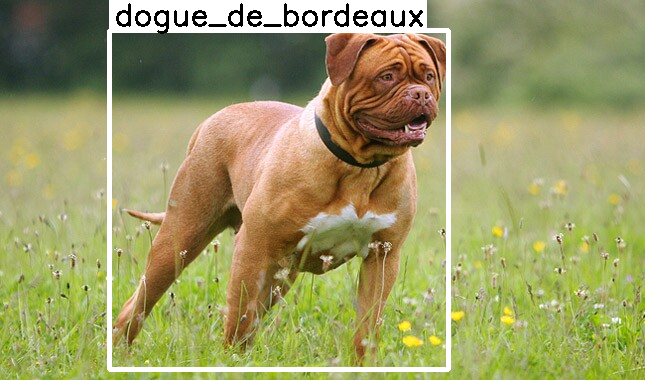

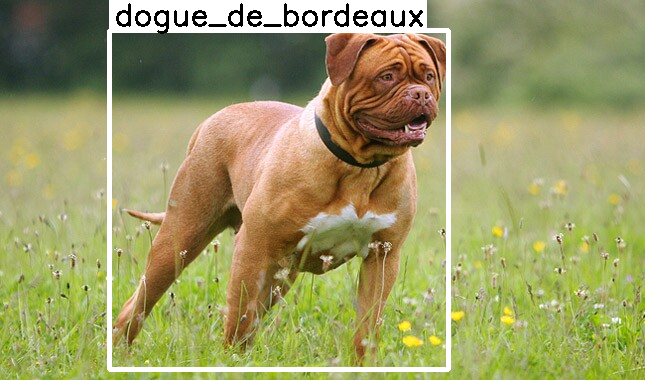

In [9]:
from IPython.display import Image, display

display(dataset.visualize.ShowBoundingBoxes(1))
display(dataset.visualize.ShowBoundingBoxes("dogue_de_bordeaux_0040.jpg"))

In [17]:
dataset.splitter.StratifiedGroupShuffleSplit(
    train_pct=0.7, test_pct=0.1, val_pct=0.2, batch_size=1, cat_col="cat_id"
)
dataset.analyze.ShowClassSplits(normalize=True)

Splitting dataset: 3499it [00:13, 252.51it/s]                          


,all,train,test,val
cat_name,,,,


# Export to Yolo v5
The PyLabel exporter will export all of the annotations in the dataframe to the desired target format.
Yolo creates one text file for each image in the dataset. 

In [7]:
dataset.path_to_annotations = "../data/renamed_dub_removed"
dataset.export.ExportToYoloV5()[0]

Exporting YOLO files...: 100%|██████████| 108/108 [00:00<00:00, 1392.81it/s]


'training/dataset.yaml'

In [ ]:
dataset.export.ExportToYoloV5(
    output_path="../data/split_yolo",
    yaml_file="dataset.yaml",
    copy_images=True,
    use_splits=True,
)

In [19]:
import torchvision

In [20]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

/opt/homebrew/Caskroom/miniforge/base/envs/helloDogBreed/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/helloDogBreed/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /Users/tillmeineke/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:51<00:00, 3.24MB/s] 


In [21]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
class CustDat(torch.utils.data.Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.df.iloc[idx, 0])
        image = Image.open(img_name)
        image = image.convert("RGB")
        image = np.array(image)
        image = image / 255.0
        image = np.transpose(image, (2, 0, 1))
        
        boxes = self.df.iloc[idx, 1:5].values
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        labels = torch.tensor([1], dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return image, target